# NMR Inversion Recovery Analysis in Python

<strong>Author(s):</strong> Seth D. Veenbaas, Jessica A. Nash, The Molecular Sciences Software Institute

<div class="alert alert-block alert-info"> 
<h2>Overview</h2>

<strong>Objective:</strong>

* Use Pandas and Scipy to proceed NMR data.

* Use Matplotlib to visualize data.

* Calculate the T<sub>1</sub> relaxation times.

* Calculate an ideal d<sub>1</sub> delay time.

</div>

## Inversion recovery experiment
The inversion-recovery experiment measures $T_1$ relaxation times of any nucleus. If the net magnetization is placed along the -z axis, it will gradually return to its equilibrium position along the +z axis at a rate governed by $T_1$. The equation governing this behavior as a function of the time t after its displacement is: 

$$ M_z(t) = M_{z,\text{eq}} \cdot \left(1 - 2e^{-t/T_1}\right) $$

The basic pulse sequence consists of an 180<sup>°</sup> pulse that inverts the magnetization to the -z axis. During the following delay, relaxation along the longitudinal plane takes place. Magnetization comes back to the original equilibrium z-magnetization. A 90<sup>°</sup> pulse creates transverse magnetization. The experiment is repeated for a series of delay values taken from a variable delay list. A 1D spectrum is obtained for each value of vd and stored in a pseudo 2D dataset. The longer the relaxation delay (d<sub>1</sub>) is, the more precise the T<sub>1</sub> measurement is. An ideal relaxation time (d<sub>1</sub>) can be calculated (aq = acquisition time):

 $$ d_1 + \text{aq} = 5 \cdot T_1 $$

 <br>

![image.png](images/t1_relaxation_pulse_sequence.png)

More information:
https://imserc.northwestern.edu/downloads/nmr-t1.pdf



## Importing Required Libraries

First, let's import the python libraries/packages we need to work with the data.


In [12]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import mnova
import rdkit
from rdkit.Chem import Draw

# Enable inline plotting
%matplotlib inline

# Set DataFrame precision to 3 decimal places
pd.set_option("display.precision", 3)


## Inversion recovery of ibuprofen

We will be analyzing <sup>1</sup>H inversion recovery from ibuprofen today.

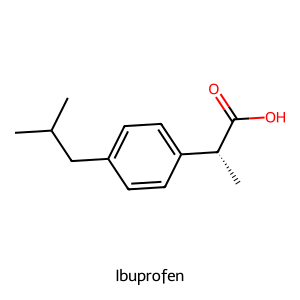

In [13]:
ibuprofen = rdkit.Chem.MolFromSmiles('CC(C)Cc1ccc(cc1)[C@@H](C)C(=O)O')
Draw.MolToImage(ibuprofen, legend='Ibuprofen')

## Importing the Data

We will now import the NMR inversion recovery data from a CSV file to a Pandas Dataframe (the excel of Python).

The file `Ibuprofen-C13-invrec-data-mnova.csv` contains the experimental data from an inversion recovery experiment for ibuprofen.

In [14]:
# Load the data from the CSV file
ibuprofen_inversion_data = pd.read_csv('data/Ibuprofen_CDCl3_1H_inversion_recovery.csv')

# Display the first 5 row of the dataframe
ibuprofen_inversion_data.head()

,#,X(I),Y(X),Y'(X),Y1(X),Y1'(X),Y2(X),Y2'(X),Y3(X),Y3'(X),Y4(X),Y4'(X),Y5(X),Y5'(X),Y6(X),Y6'(X)
0,Model,ARR_DATA(I),"Integral(7.267,7.205)",G= 0.441982,"Integral(7.170,7.095)",G= 0.460624,"Integral(3.801,3.673)",G= 0.479853,"Integral(2.529,2.438)",G= 0.869925,"Integral(1.948,1.813)",G= 0.5077,"Integral(1.576,1.475)",G= 1.36596,"Integral(0.977,0.877)",G= 0.888414
1,1,0.001,-58232194.01,-57945240.43,-58692047.98,-58361598.29,-29709785.69,-29459900.71,-57613893.58,-57808210.86,-28631154.96,-28310009.87,-85653399.11,-85854489.01,-172088001.5,-172109180.5
2,2,0.05,-55423870.79,-55285926.21,-55795304.01,-55572543.06,-28165575.32,-27983108.74,-52543436.35,-52597552.83,-27083143.7,-26797202.88,-73764986.78,-73778129.59,-156172078.9,-156133950.8
3,3,0.1,-52755384.65,-52631061.57,-52938126.65,-52790722.47,-26648227.67,-26511548.69,-47482133.19,-47504636.18,-25327411.02,-25291831.74,-62254865.7,-62260890.66,-140524942.5,-140533982.8
4,4,0.25,-44941828.63,-45009582.11,-44699628.79,-44819544.52,-22119318.66,-22302898.44,-33586678.5,-33490017.16,-20837213.36,-20998356.29,-32227670.87,-32073778.08,-97540283.92,-97684336.23


### Use the `mnova.rename_columns()` function to reformat the Dataframe.

The format will make the data easier to work will.

|        Time(s)         |           <#>_ppm            |
| :--------------------: | :--------------------------: |
| Time of scan (seconds) | Chemical shift of each peak. |

In [15]:
# Runs reformating function
ibuprofen_inversion_data = mnova.rename_columns(ibuprofen_inversion_data)

# Display the first 5 row of the dataframe
ibuprofen_inversion_data.head()

,Time(s),7.2_ppm,7.1_ppm,3.7_ppm,2.5_ppm,1.9_ppm,1.5_ppm,0.9_ppm
1,0.001,-5.823e+07,-5.869e+07,-2.971e+07,-5.761e+07,-2.863e+07,-8.565e+07,-1.721e+08
2,0.050,-5.542e+07,-5.580e+07,-2.817e+07,-5.254e+07,-2.708e+07,-7.376e+07,-1.562e+08
3,0.100,-5.276e+07,-5.294e+07,-2.665e+07,-4.748e+07,-2.533e+07,-6.225e+07,-1.405e+08
4,0.250,-4.494e+07,-4.470e+07,-2.212e+07,-3.359e+07,-2.084e+07,-3.223e+07,-9.754e+07
5,0.500,-3.308e+07,-3.234e+07,-1.562e+07,-1.404e+07,-1.418e+07,6.064e+06,-3.781e+07


<div class="alert alert-block alert-warning">
<h3>Challange</h3>

Use `plot()` to visualize the inversion recovery signals in `ibuprofen_inversion_data`.

**Tip**: plot `Time(s)` on the x-axis.

</div>

### [`DataFrame.plot()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

Make plots of a DataFrame.

#### Parameters

- **x** : `str` of column name, *(default: `None`)*

    The column to use for the x-axis (independent variable).

- **y** : `str` or `list` of column name(s), *(default: `None`)*

    The column(s) to use for the y-axis (dependent variable).

- **kind** : `str`, *(Default: `'line'`)*

    The kind of plot to produce (e.g., `'bar'`, `'hist'`, `'scatter'`)

<Axes: xlabel='Time(s)'>

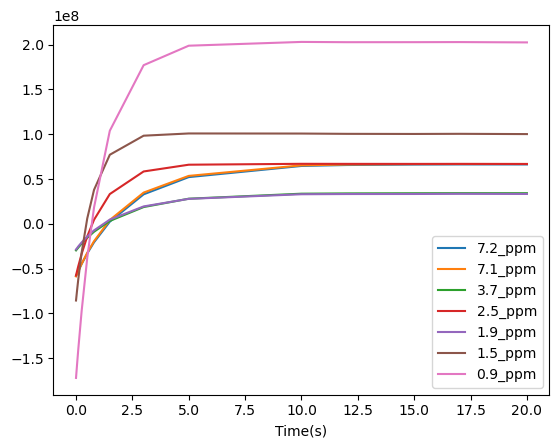

In [16]:
# Plot the data from all peaks vs. Time(s)
ibuprofen_inversion_data.plot(x='Time(s)')

## Calculate $T_1$ relaxation time

We will use the `curve_fit()` function from scipy to fit our data to the exponential inversion recovery model:

$$
M_z(t) = {\color{red} M_{z,\text{eq}}} \cdot \left(1 - 2e^{-t/{\color{red} T_1}}\right) + {\color{red} C}
$$

The `curve_fit()` function with optimize the three parameters in our inversion recovery model using our experimental data.

$$
parameters = {\color{red} M_{z,\text{eq}}}, {\color{red} T_1}, {\color{red} C}

$$

<br>

Let's use `curve_fit()` with our data from the peak at 0.9 ppm to determine an optimal value for $T_1$!

In [17]:
# Extract data for the peak at 0.9 ppm
time_data = ibuprofen_inversion_data['Time(s)']
peak_data = ibuprofen_inversion_data['0.9_ppm']

# Define the inversion recovery model with the parameters (M, T1, and C)
def inversion_recovery_model(time, M, T1, C):
    return M * (1 - 2 * np.exp(-time / T1)) + C

# Initial guess for our three parameters (M, T1, and C)
initial_guess = [max(peak_data), 1, min(peak_data )]

# Fit the curve to get optimized parameters (M, T1, and C)
param_optimal, _ = curve_fit(inversion_recovery_model, time_data, peak_data, p0=initial_guess)

# Print optimized parameters
print(param_optimal)


[1.87676518e+08 1.12561180e+00 1.52345369e+07]


The second value above is the $T_1$ time (s) for the peak at 0.9 ppm!

## Code reusability: calculate $T_1$ for all peaks

Great, We calculated $T_1$! Now just 6 more peaks to go....

Don't worry, we can reuse our code to do repetitive tasks if we design it properly.

Two really powerful tools for reusing code are:
- defining custom functions
- `for` loops

## How to Define a Function
1. **Keyword**: Use the `def` keyword to start the definition.  
2. **Name**: Choose a descriptive name for the function (e.g., `calculate_energy`).  
3. **Parameters**: Enclose optional input parameters in parentheses `()`.  
4. **Colon**: Add a colon `:` to indicate the start of the function body.  
5. **Indented Body**: Write the function's logic as an indented block (4 spaces).
6. **Optional Docstring**: Explains what a function does, what the parameters are, and what the function returns (if any).
7. **Optional Return**: Use `return` to send a result back to the caller (if needed).


### Here is what it looks like to define a function:
```python
def function_name(parameters):
    # Optional: explain what your function does in a Docstring
    """
    Docstring
    """
    # Function body (indented code)
    return output  # Optional: Return a result
```
<br>

Let's create a function that we can reuse to plot our fitted data!

In [18]:
def plot_fitted_data(df, time_col, peak_col, param_optimal):
    """
    Plots the peak intensity vs. time data along with the fitted inversion recovery model.

    Parameters:
    - df (pd.DataFrame): The input DataFrame containing the data to be plotted.
    - time_col (str): The column name in the DataFrame representing time data.
    - peak_col (str): The column name in the DataFrame representing peak intensity data.
    - param_optimal (np.ndarray): Optimal parameters from the curve fitting (M_z,eq, T1, C) returned by `curve_fit`.

    Returns:
    - None: This function directly displays the plot using `matplotlib.pyplot.show()`.

    The function creates a scatter plot of the peak intensity vs. time and overlays a curve fit based on the 
    inversion recovery model. The fitted T1 value is displayed in the plot legend.
    """
    time_data = df[time_col]
    peak_data = df[peak_col]
    
    # Create a blank figure
    plt.figure(figsize=(8, 6))
    
    # Plot peak intensity vs. time as a scatter plot
    plt.scatter(time_data, peak_data, label=f'{peak_col} Data')
    
    # Plot curve fit
    x_model = np.linspace(min(time_data), max(time_data), 100)
    y_model = inversion_recovery_model(x_model, *param_optimal)
    plt.plot(x_model, y_model, label=f'Fit: T1 = {param_optimal[1]:.3f} s', color='red')
    
    # Add labels, title, and legend
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Signal intensity', fontsize=12)
    plt.title(f'Inversion Recovery Fit for peak {peak_col}',  fontsize=14)
    plt.legend(loc='lower right')
    
    # Show the plot
    plt.show()


<div class="alert alert-block alert-warning">
<h3>Challange</h3>

Create a custom function that performs a curve fit to our inversion recovery model.

You do not need to write a doc string but do incorporate the following:

#### 1. Function Name: `fit_relaxation_data`

#### 2. Parameters:

- `time_data` (list): Time points for the relaxation curve.
- `peak_data` (list): Corresponding peak intensities.

#### 3. Function body (indented code):

```python
# Initial guess for our three parameters (M, T1, and C)
initial_guess = [max(peak_data), 1, min(peak_data )]

# Fit the curve to get optimized parameters (M, T1, and C)
param_optimal, _ = curve_fit(inversion_recovery_model, time_data, peak_data, p0=initial_guess)
```

#### 4. Return:

- `param_optimal` Optimal parameters for the inversion recovery model (M_z,eq, T1, C)

</div>


In [19]:
# Write the custom function `fit_relaxation_data`
def fit_relaxation_data(time_data, peak_data):
    # Initial guess for M, T1, and C
    initial_guess = [max(peak_data), 1.0, min(peak_data)]
    
    # Fit the curve
    param_optimal, _ = curve_fit(inversion_recovery_model, time_data, peak_data, p0=initial_guess)
    
    return param_optimal

## How to Write a for Loop
1. **Keyword**: Start with `for`.
2. **Iterator Variable**: Specify a variable for each item.
3. **`in` Keyword**: Use in to specify the sequence.
4. **Colon**: Add a colon `:` to start the loop body.
5. **Indented Body**: Indent the code to execute in each iteration.

### Here is what it looks like to write a `for` loop:

```python
for each_item in your_items:
    # Code to be executed for each_item (indented code)
```

<br>

Let's create a `for` loop that:
* Uses `fit_relaxation_data` to fit the data for every peaks.
* Uses `plot_fitted_data` to plot the fit for every peaks.
* Creates a DataFrame called `t1_data` to save the T<sub>1</sub> time for all our peaks.

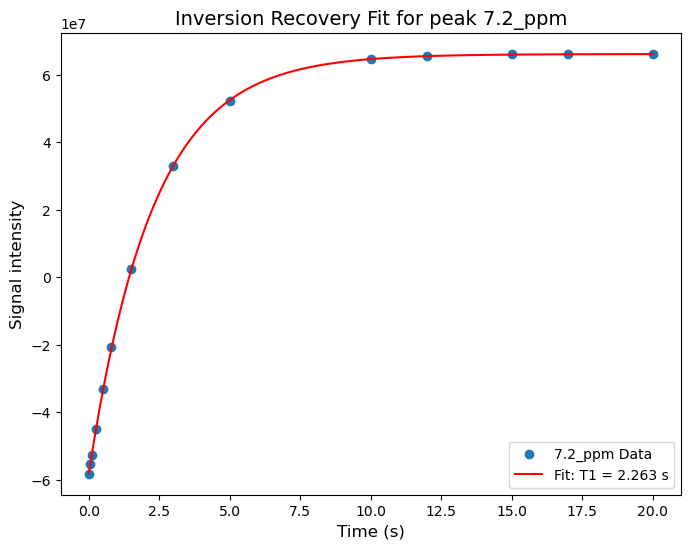

/tmp/ipykernel_35893/2119918285.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  t1_data = pd.concat([t1_data, new_row], ignore_index=True)


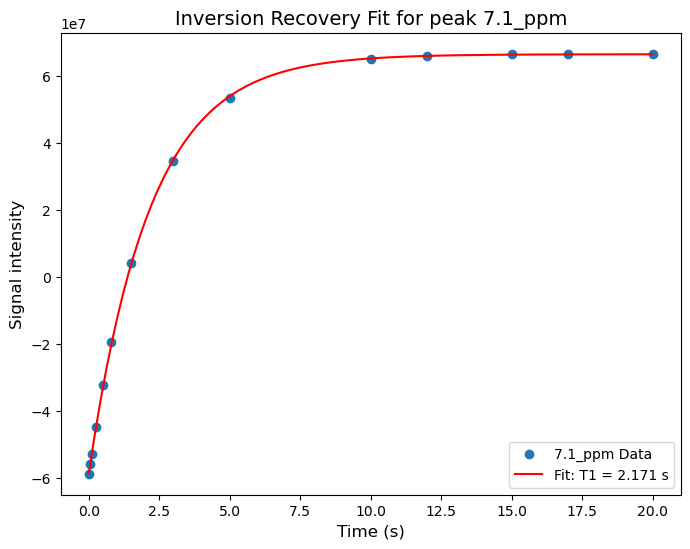

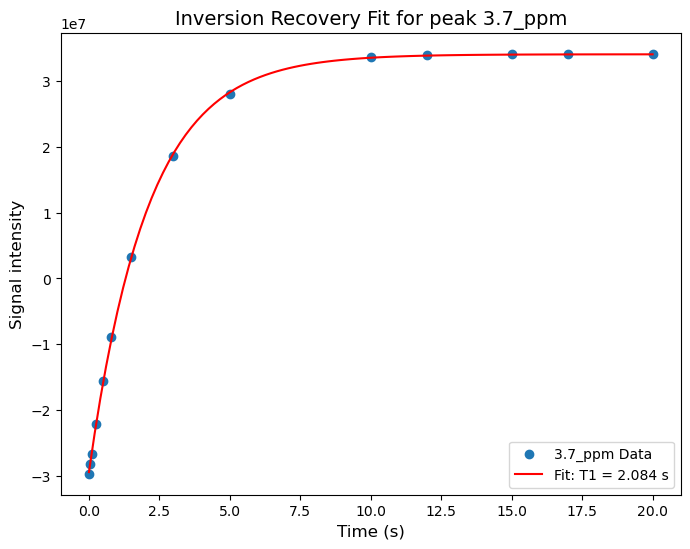

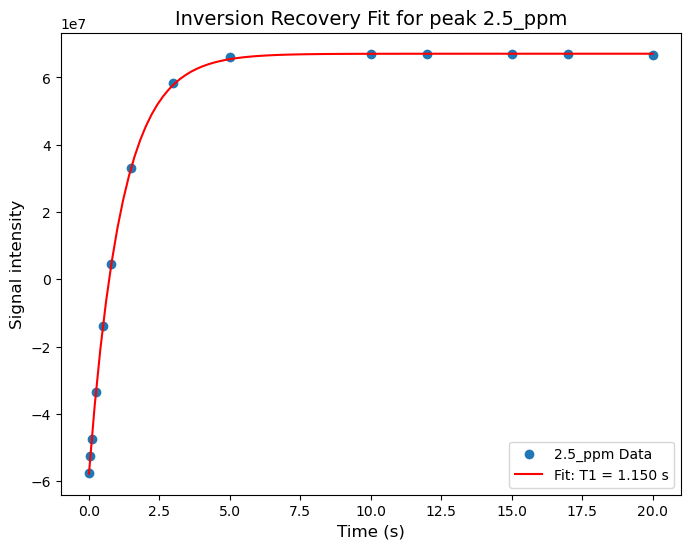

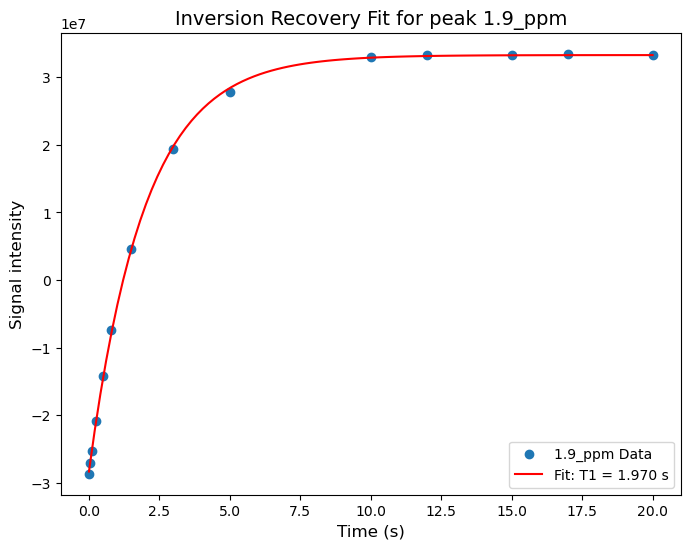

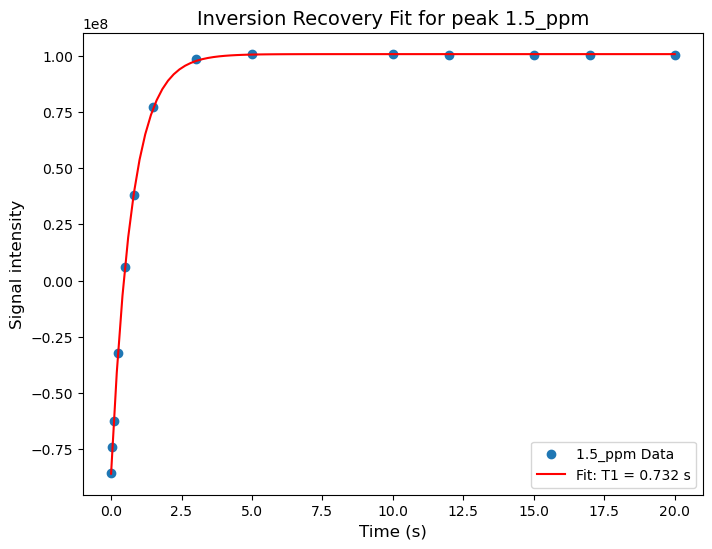

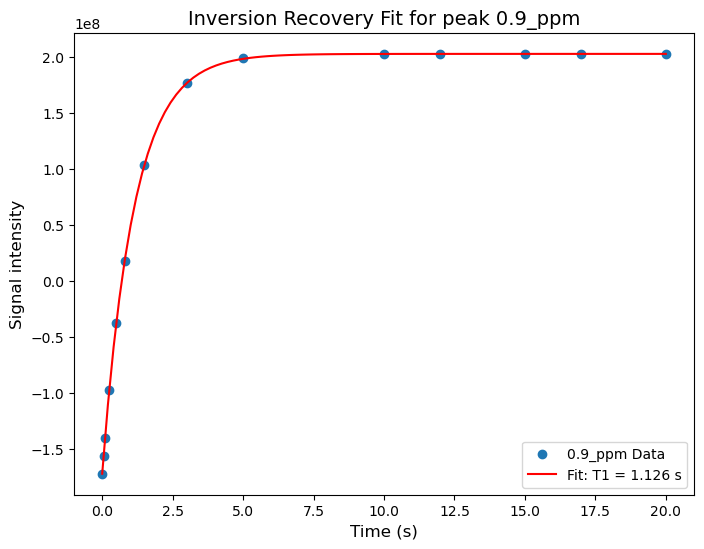

,Peak,T1(s)
0,7.2_ppm,2.263
1,7.1_ppm,2.171
2,3.7_ppm,2.084
3,2.5_ppm,1.150
4,1.9_ppm,1.970
5,1.5_ppm,0.732
6,0.9_ppm,1.126


In [20]:
# Define what DataFrame to use to improve reusability.
df = ibuprofen_inversion_data

# Create an empty DataFrame for t1_data with columns 'Peak' and 'T1(s)'
t1_data = pd.DataFrame(columns=['Peak', 'T1(s)'])

# Calculate T1 for each peak and plot the fit
for column in df.columns[1:]:
    
    # Fit relaxation data to calculate T1
    time_data = df['Time(s)']
    peak_data = df[column]
    param_optimal = fit_relaxation_data(time_data, peak_data)
    T1 = param_optimal[1]
    
    # Plot the fitted data
    plot_fitted_data(df, 'Time(s)', column, param_optimal)
    
    # Add T1 time to the t1_data DataFrame
    new_row = pd.DataFrame({'Peak': [column], 'T1(s)': [T1]})
    t1_data = pd.concat([t1_data, new_row], ignore_index=True)

# Display `t1_data` DataFrame
t1_data


## Calculate Ideal Delay Time ($d_1$)

We can calculate an ideal delay time $d_1$ for future NMR experiments based on the measured $T_1$ times. The relationship is given by the formula:

$ d_1 + \text{aq} = 5 \times T_1 $

or

$ d_1 = (5 \times T_1) - \text{aq} $

Where:
- $d_1$ is the ideal delay time (seconds).
- $\text{aq}$ (acquisition time) = 0.7 seconds (Bruker default for <sup>1</sup>H).
- $T_1$ is the longitudinal relaxation time (seconds).

<br>

<div class="alert alert-block alert-warning">
<h3>Challange</h3>

Use the $T_1 $ times in `t1_data['T1(s)']` to calculate ideal delay times $d_1$ and save the results to `t1_data['D1(s)']`.

Display the `t1_data` DataFrame to check your work.

</div>

### Syntax for setting a new column in a DataFrame

```python
DataFrame_name['Grams'] = DataFrame_name['Kilograms'] / 1000
```

In [21]:
# Define the acquisition time (aq)
aq = 0.7 # Bruker default for 1H experiment

# Calculate D1 delay time using vectorized operations
t1_data['D1(s)'] = (5 * t1_data['T1(s)'] - aq)

# Display Dataframe
t1_data


,Peak,T1(s),D1(s)
0,7.2_ppm,2.263,10.613
1,7.1_ppm,2.171,10.155
2,3.7_ppm,2.084,9.720
3,2.5_ppm,1.150,5.048
4,1.9_ppm,1.970,9.148
5,1.5_ppm,0.732,2.960
6,0.9_ppm,1.126,4.928


## Export results

You can export a DataFrame from pandas to a CSV file using the `DataFrame.to_csv()` method. 

### [DataFrame.to_csv()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html)

Write a DataFrame to a CSV file.

#### Parameters

- **path_or_buf** : `str`, *(default: `None`)*

    The file path or object to write the CSV data. If `None`, the result is returned as a string.

- **index** : `bool`, *(default: `True`)*

    Whether to write row names (index). If `False`, the index is not written.

<br>

Let's export the formatted `ibuprofen_inversion_data` DataFrame!

In [22]:
ibuprofen_inversion_data.to_csv(path_or_buf='results/ibuprofen_CDCl3_1H_inversion_recovery_data.csv', index=False)

<div class="alert alert-block alert-warning">
<h3>Challange</h3>

Export the `t1_data` DataFrame to the path `'results/ibuprofen_CDCl3_1H_T1_data.csv'`.

See what happens if you set `index=True`.

</div>

In [23]:
# Export `t1_data` DataFrame to 'results/ibuprofen_CDCl3_1H_T1_data.csv'
t1_data.to_csv(path_or_buf='results/ibuprofen_CDCl3_1H_T1_data.csv', index=True)